# Causal Inference Introduction (with DoWhy)

This is a soft introduction to how to practically use causal inference. This notebook will assume that you have worked with your domain experts to build a directed acyclic graph and will focus on the modelling side of causal inference and how to calculate treatment effects.

This notebook also does not motivate causal inference as we have covered this in many DS chats, see the following for a nice introduction to [correlation vs causation](https://matheusfacure.github.io/python-causality-handbook/01-Introduction-To-Causality.html).

In [1]:
%%capture
!pip install dowhy
!pip install econml

In [97]:
import dowhy
import dowhy.datasets
import econml
from econml.dml import DML, LinearDML, SparseLinearDML, CausalForestDML
import matplotlib.pyplot as plt
import numpy as np

## Simulate Some Data

Luckily, there are packages that can help us to produce a simulated dataset that consists of:

"Causes": a feature(s) that causes some outcome.\
"Instruments": a feature(s) that impacts the "cause".\
"Treatment": a feature(s) that we are "changing" or "applying". Like changing a price or testing a drug.

This function also allows us to decide if the treatment or outcome is binary or not. Some examples of each could be:

binary treatment: "taken the drug or not?"\
binary outcome: "did cure the disease or not?"

continuous treatment: "how much did I increase my price?"\
continous outcome: "what profit did I observe?"

In [67]:
data = dowhy.datasets.linear_dataset(
    beta=10, #coeficient of the treatment
    num_common_causes=3, #impacts outcome and treatment
    num_samples=10000, #number of records
    treatment_is_binary=False, #is the treatment binary? 
    outcome_is_binary=False,
    ) #is the outcome binary?

Lets make this feel more real with an airline pricing example

In [68]:
data['outcome_name'] = 'profit'
data['common_causes_names'] = ['day of week', 'route type', 'days to go']
data['treatment_name'] = 'ticket price'
data['df'] = data['df'].rename(columns={'W0': 'day of week', "W1": "route type", "W2": "days to go", "v0": "ticket price", "y": "profit"})

#### What is our true treatment effect?
What are we trying to learn? This is the causal effect of our treatment on our outcome

In [77]:
print("true ATE = ", data['ate'])

true ATE =  10.000128551358173


#### How does this look as a DAG? 

First we can initialise our causal model

In [78]:
model = dowhy.CausalModel(
    data=data["df"], #our simulated dataset
    treatment=data["treatment_name"], #our treatment(s)
    outcome=data["outcome_name"], #our outcome
    common_causes=data["common_causes_names"], #our common causes
    instruments=data["instrument_names"] # no instruments in this example
)

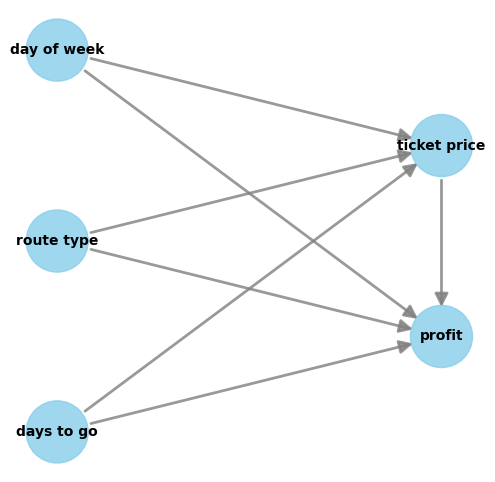

In [79]:
model.view_model(size=(6,6))

## Identify Effect

We call the identify_effect method to determine if the causal effect of ticket price on profit can be identified from the data and causal assumptions.

The output identification formula will indicate the method to be used to estimate the causal effect. For example, it might suggest using:

Backdoor Adjustment: The backdoor adjustment is a method in causal inference used to estimate the causal effect of a treatment (or intervention) on an outcome by controlling for confounders.

Instrumental Variables: Instrumental Variables (IV) are used to estimate causal effects when there is unmeasured confounding between the treatment and the outcome. An instrumental variable is a variable that is correlated with the treatment but affects the outcome only through the treatment.

Frontdoor Adjustment: The frontdoor adjustment is a method in causal inference used to estimate the causal effect of a treatment on an outcome when there is a mediator that lies on the causal path from the treatment to the outcome.

We can see in our case, backdoor adjustment is needed.

In [81]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

In [84]:
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                    
───────────────(E[profit|days to go,day of week,route type])
d[ticket price]                                             
Estimand assumption 1, Unconfoundedness: If U→{ticket price} and U→profit then P(profit|ticket price,days to go,day of week,route type,U) = P(profit|ticket price,days to go,day of week,route type)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Estimate Causal Effect

We can now use the estimate effect method to get the treatment effect. 

The control value and treatment value can be thought of as "what profit change will I observe if I change my ticket price from "control value" to the "treatment value""

We initialised the beta or gradient to be 10. Therefore a change in 1 unit price should lead to a profit increase of 10 units.

In [130]:
linear_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    control_value=0,
    treatment_value=1
)

linear_estimate.interpret()

Increasing the treatment variable(s) [ticket price] from 0 to 1 causes an increase of 10.000187998164186 in the expected value of the outcome [['profit']], over the data distribution/population represented by the dataset.


For binary treatments, one can use 
```
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_matching",
                                target_units="att")
print(estimate)
```

## Refute

In DoWhy, the refute_estimate method is used to test the robustness and validity of the estimated causal effect. Refutation helps to assess whether the estimated causal effect might be due to unobserved biases, model misspecification, or other issues rather than a true causal relationship.

**Placebo Treatment Refuter**: The estimated effect should be close to zero if the placebo treatment truly has no effect.

**Random Common Cause Refuter**: Introducing a random common cause should not significantly change the estimate if unobserved confounding is not an issue.

**Data Subset Refuter**: The estimates from subsets should be similar to the original estimate, indicating stability across different data segments.

**Bootstrap Refuter**: The bootstrap distribution should be centered around the original estimate, indicating that the estimate is not overly sensitive to random variations in the data.


In [132]:
# Refute the causal effect estimate using Placebo Treatment Refuter
refutation_placebo = model.refute_estimate(
    identified_estimand,
    linear_estimate,
    method_name="placebo_treatment_refuter"
)
print("Refutation with Placebo Treatment:")
print(refutation_placebo)

# Refute the causal effect estimate using Random Common Cause Refuter
refutation_random_common_cause = model.refute_estimate(
    identified_estimand,
    linear_estimate,
    method_name="random_common_cause"
)
print("Refutation with Random Common Cause:")
print(refutation_random_common_cause)

# Refute the causal effect estimate using Data Subset Refuter
refutation_data_subset = model.refute_estimate(
    identified_estimand,
    linear_estimate,
    method_name="data_subset_refuter"
)
print("Refutation with Data Subset:")
print(refutation_data_subset)

# Refute the causal effect estimate using Bootstrap Refuter
refutation_bootstrap = model.refute_estimate(
    identified_estimand,
    linear_estimate,
    method_name="bootstrap_refuter"
)
print("Refutation with Bootstrap:")
print(refutation_bootstrap)

Refutation with Placebo Treatment:
Refute: Use a Placebo Treatment
Estimated effect:10.000187998164186
New effect:-5.329070518200751e-15
p value:0.0

Refutation with Random Common Cause:
Refute: Add a random common cause
Estimated effect:10.000187998164186
New effect:10.00018798947355
p value:0.92

Refutation with Data Subset:
Refute: Use a subset of data
Estimated effect:10.000187998164186
New effect:10.000188792658404
p value:1.0

Refutation with Bootstrap:
Refute: Bootstrap Sample Dataset
Estimated effect:10.000187998164186
New effect:10.091800706378846
p value:0.0

